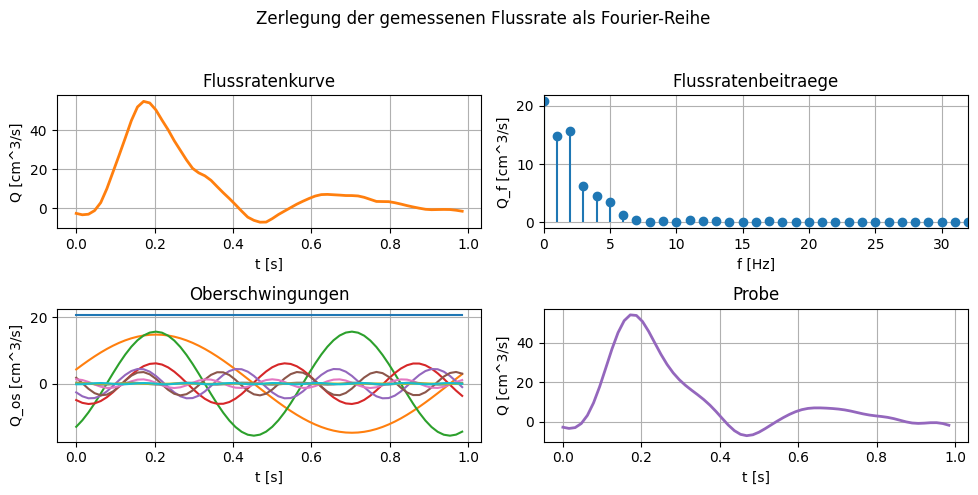

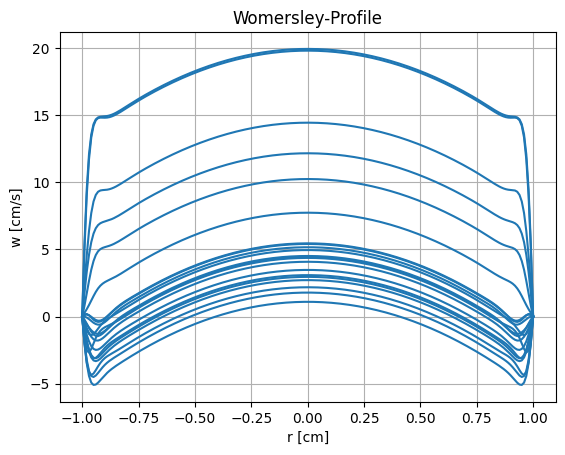

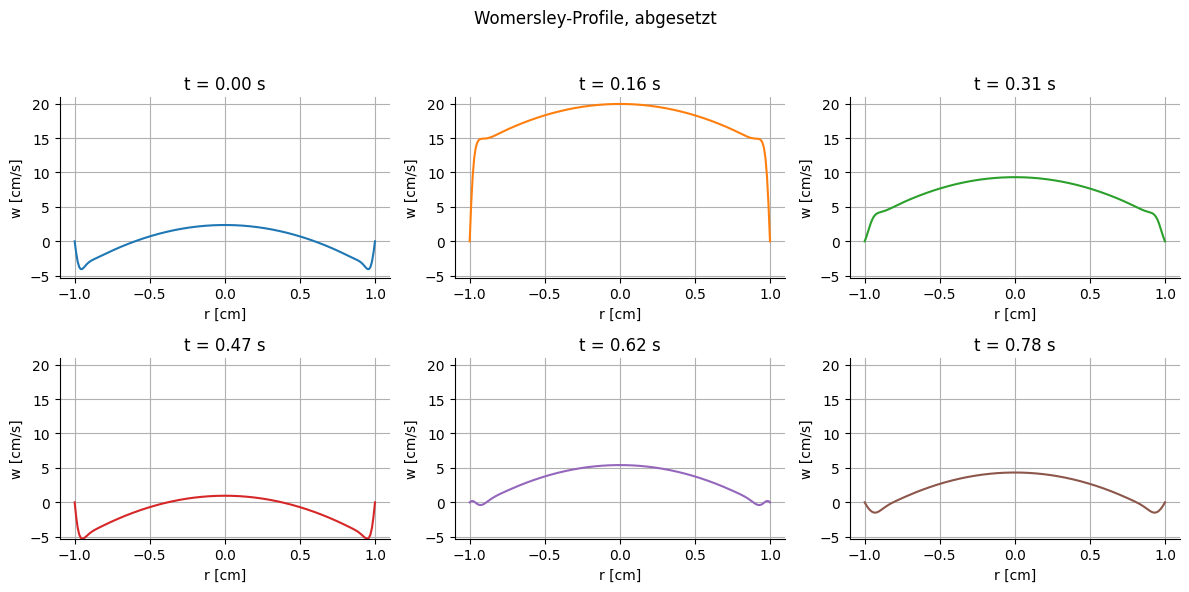

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from IPython.display import HTML


# Beispielhafte Anwendung
def Aufgabe2_Womersley():

    # ECKDATEN: Parameter
    # Radius des Blutgefaesses [cm]
    R = 1.0        

    #Herzzyklus [s]
    T_signal = 1.0

    # Anzahl der verwendeten Oberschwingungen aus Fourierreihe
    N = 10    
    
    # dynamische Viskositaet des Blutes [g/(cm*s)], eta_0 = 0.04
    eta = 0.04 * 1.0   
    
    # Dichte des Blutes [g/cm^3]
    rho = 10.055 * 1.0 # 
    
### Berechnung
############################################################### CODING ###########################################################################
############################################################ DO NOT TOUCH ##########################################################################
##################################################################################################################################################
    # Radiale Auflösung
    r_res = 200
    r = np.linspace(-1, 1, r_res) * R
    
    ## Zerlegung der gemessenen Flussratenkurve als Fourier-Reihe
    # IN :  T_signal - Signaldauer [s]
    #       R        - Gefäßradius [cm]
    # OUT:  Q_0      - Zeitlicher Verlauf der Flussrate
    #                  gemessene Flussrate [cm^3/s]
    Q_0 = Flussrate(T_signal, R)

 
    ## Fourieranalyse der Flussrate
    # IN :  Q_0, T_signal
    # OUT:  Q_fft     - Fourierreihenzerlegung von Q_0
    #       Q_int     - Interpoliertes (Anfangs-)Signal zur Verifizierung der FFT
    #       t         - Zeitvektor [s]
    Q_fft, Q_int, t = Fastfourier(Q_0, T_signal)

    ## Synthese der Oberschwingungen
    # Definition des Frequenzvektors (nur halbes Spektrum, da achsensymmetrisch)
    # IN :  Q_fft, T_sample  
    # OUT:  M         - Amplituden der Oberschwingungen 
    #       phi       - Phasenversatz der Oberschwingungen 
    #       f         - Frequenzvektor 
    M, phi, f = SchwingungsSynthese(Q_fft, T_signal)

    # Berechnung der Flussratenanteile
    # IN : M, phi, N, f, t
    # OUT:
    #       Q        - Flussratenanteile nach Oberschwingungen
    #       Q_probe  - synthetisierte Flussrate    
    Q, Q_probe = FlussratenAnteile(M, phi, N, f, t)

    # Plot Flussratenkurve
    PlotFlussrate(t, Q_int, f, M, N, phi, Q_probe)

## Lösung der Navier-Stokes-Gleichung
        
# 1. Stationärer Teil (n = 0), Poiseuille-Strömung
# IN :  Q[0,0], R, r, t
# OUT:  W_stat  - stationärer Geschwindigkeitsanteil
    W_stat = Poiseuille(Q[0,0], R, r, t)

    # Fuer spaetere Ausgabe je Oberschwingung
    w = np.zeros((len(r), N * len(Q_int)))
    w[:, :len(Q_int)] = W_stat

# 2. Instationaerer (Womersley) Teil (1. bis N. Oberschwingung)
#       IN :  Q_n, R, r, t, alpha_n
#       OUT:  W_wom   instationaere Anteile je Oberschwingung
    W_wom = np.zeros_like(W_stat)
    
    # Womersleyzahlen der Oberschwingungen
    alpha_n = np.zeros(N-1)

    for n in range(2, N+1):
        #Womersleyzahl der aktuellen Oberschwingung
        alpha_n[n-2] = np.sqrt(2 * np.pi * f[n-1] * rho / eta) * R
        
        #Geschwindigkeitsprofil fuer n-te Oberschwingung
        Q_n = Q[:, n-1]
        w_n = Womersley(Q_n, R, r, t, alpha_n[n-2])
        
        #1. Superponierte Loesung
        W_wom += w_n
        
        #2. Loesung je Harmonische
        w[:, (n-2)*len(Q_int):(n-1)*len(Q_int)] = w_n

    W = W_stat + W_wom

    # Plot der Womersley-Loesung
    ani = PlotWomersley(R, r, t, W)


def Fastfourier(signal, T_signal):
# Fast Fourier Transform mock up
# signal_   Signalvektor
# Tsig_     Periodendauer der Flussrate / des Signals

    
    #Laenge des Signals, Anzahl Abtastpunkte
    L = len(signal)

    # fuer FFT
    # Aufstockung der Anzahl der Abtastpunkte auf naechsthoehere 2er-Potenz
    N = 2**int(np.ceil(np.log2(L)))  
    
    # Abtastschrittweite    
    T_sample = T_signal / N
    
    # Zeitvektor    
    t = np.arange(0, T_signal, T_sample)
    
    # Interpolation der Flussraten-Werte, auf np Werte aufgestockt
    signal_int = np.interp(np.linspace(0, L-1, N), np.arange(L), signal)

    #Fast Fourier Trafo
    FFT = np.fft.fft(signal_int) / N
    return FFT, signal_int, t

def Flussrate(T_signal, R):
    """
    Gibt die Flussrate als Vektor zurück
    
    IN : T_signal, R
    OUT: Q_0   - flussrate zeitlicher Verlauf der Flussrate [cm^2/s]
    
    """
    # Periodendauer der gemessenen Flussrate 
    T_0 = 1.0  #[s]

    # Querschnittsflaeche des Gefaesses, von welchem diese Messung stammt
    A_0 = 4.97  # [cm^2]
    
    # Querschnittsflaeche des Modells
    A = np.pi * R**2

    # Durchschnittsgeschwindigkeit im Blutgefaess [cm/s]
    v_mean = (T_0 / T_signal) * (A_0 / A_0) * 0.1 * np.array([-5.05, -6.56, -5.8, -1.29, 8.48,
              25.78, 44.58, 62.63, 82.18, 100.98, 110, 110, 103.23, 91.95,
              81.43, 69.39, 58.87, 48.34, 39.32, 35.56, 32.55, 26.53, 19.01,
              13, 6.23, -0.54, -8.06, -11.82, -14.07, -14.07, -10.31,
              -5.8, -2.04, 1.72, 5.48, 8.48, 11.49, 13.9, 14.65, 14.2,
              13.9, 13.3, 13.3, 13, 11.49, 9.24, 6.98, 7.13, 6.98,
              5.48, 3.97, 2.17, 0.96, -0.54, -1.29, -1.14, -0.99,
              -0.99, -1.74, -2.8])
    
    # Flussrate [cm^2/s]
    flussrate = A_0 * v_mean
    
    return flussrate


def SchwingungsSynthese(FFT, T_signal):
# Def. des Frequenzvektors (nur halbes Spektrum, da achsensymm.)
# Anzahl der Oberschwingungen 
    n_os = len(FFT) // 2
    f = (1 / T_signal) * np.arange(0, n_os + 1)
    
    # Amplitudenvektor der Oberschwingungen    
    moduli = 2 * np.abs(FFT[:n_os + 1])

    # Phasenversatzvektor zwischen Real- und Imaginaerteil
    phi = np.arctan2(-FFT[:n_os + 1].imag, FFT[:n_os + 1].real)
    
    return moduli, phi, f


def FlussratenAnteile(moduli, phi, N, f, t):
    """
    Synthetisiert die Flussratenanteile der Oberschwingungen
    
    IN:
        moduli - Amplituden der Oberschwingungen
        phi    - Phasen der Oberschwingungen
        N      - Anzahl der verwendeten Oberschwingungen
        f      - Frequenzen [Hz]
        t      - Zeitvektor [s]
    
    OUT:
        Q_os   - Oberschwingungen (Zeitkurven)
        Q_sum  - Flussrate synthetisiert aus den einzelnen Oberschwingungen
    """
    Q_os = np.zeros((len(t), N))
    
    # Konstanter Flussratenanteil
    Q_os[:, 0] = 0.5 * moduli[0]
    Q_sum = Q_os[:, 0].copy()
    
    for k in range(1, N):
        Q_os[:, k] = moduli[k] * np.cos(2 * np.pi * f[k] * t - phi[k])

         # Zur Probe
        Q_sum += Q_os[:, k]
        
    return Q_os, Q_sum


def Poiseuille(Q_stat, R, r, t):
    """
    Berechnet die Geschwindigkeit aus dem stationären Teil (n=0), Poiseuille-Strömung
    
    IN:
    Q_stat,R,r,t     
    
    OUT:
    W_stat - stationärer Geschwindigkeitsanteil [cm/s]
    """
    W_stat = np.zeros((len(r), len(t)))

    # Anteil der Flussrate
    w_stat = 2 * Q_stat / (np.pi * R**4) * (R**2 - r**2)
    
    for m in range(len(t)):
        W_stat[:, m] = w_stat
        
    return W_stat


def Womersley(Q_os, R, r, t, alpha_n):
    """
    Berechnet das zeit- und ortsabhängige Geschwindigkeitsprofil mittels Womersley-Lösung
    instationaerer (Womersley) Teil (1. bis N. Oberschwingung)
    IN:
        Q_os,R,r,t,alpha_n
    
    OUT:
        w_os    - Geschwindigkeitsprofil der Oberschwingung [cm/s]
        
    Einheiten: cm, s, g
    """
    C = 1 / (np.pi * R**2)
    z = alpha_n * 1j**1.5
    w_os = np.zeros((len(r), len(t)))
    for m in range(len(t)):
        Bessel = (z * (jv(0, z) - jv(0, z * r / R))) / (z * jv(0, z) - 2 * jv(1, z))
        w_os[:, m] = np.real(C * Q_os[m] * Bessel)
    return w_os



def PlotFlussrate(t, Q_int, f, M, N, phi, Q_probe):

# Plottet die Flussratenkurve, Amplituden, Oberschwingungen und Syntheseprobe

    
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig.suptitle('Zerlegung der gemessenen Flussrate als Fourier-Reihe')

    axs[0, 0].plot(t, Q_int, linewidth=2.0, color=colors[1])
    axs[0, 0].set_title('Flussratenkurve')
    axs[0, 0].set_xlabel('t [s]')
    axs[0, 0].set_ylabel('Q [cm^3/s]')
    axs[0, 0].grid(True)

    axs[0, 1].stem(f, M, linefmt='C0-', markerfmt='C0o', basefmt=" ")
    axs[0, 1].set_xlim([0, max(f)])
    axs[0, 1].set_title('Flussratenbeitraege')
    axs[0, 1].set_xlabel('f [Hz]')
    axs[0, 1].set_ylabel('Q_f [cm^3/s]')
    axs[0, 1].grid(True)

    for i in range(N):
        axs[1, 0].plot(t, M[i] * np.cos(2 * np.pi * f[i] * t - phi[i]), linewidth=1.5)
    axs[1, 0].set_title('Oberschwingungen')
    axs[1, 0].set_xlabel('t [s]')
    axs[1, 0].set_ylabel('Q_os [cm^3/s]')
    axs[1, 0].grid(True)

    axs[1, 1].plot(t, Q_probe, color=colors[4], linewidth=2.0)
    axs[1, 1].set_title('Probe')
    axs[1, 1].set_xlabel('t [s]')
    axs[1, 1].set_ylabel('Q [cm^3/s]')
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def PlotWomersley(R, r, t, W):
    """
    Plottet die Womersley-Geschwindigkeitsprofile
    - Überlagerte Profile (jede k-te Zeitstufe)
    - Abgesetzte Profile als Subplots
    - 3D-Rotationskörper-Animation
    """

    # 1) Überlagerte Profile
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure()
    k = 3
    for m in range(1, 2*len(t)):
        idx = k * (m - 1) + 1
        if 0 <= idx < W.shape[1]:
            plt.plot(r, W[:, idx], color=colors[0], linewidth=1.5)
    plt.title('Womersley-Profile')
    plt.xlabel('r [cm]')
    plt.ylabel('w [cm/s]')
    plt.grid(True)
    plt.show()

    # 2) Abgesetzte Profile in Subplots
    k = 10
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    axs = axs.flatten()
    ylimits = (W.min(), W.max())

    subplot_idx = 0
    for m in range(len(t)):
        idx = idx = k * m
        if 0 <= idx < W.shape[1] and subplot_idx < len(axs):
            ax = axs[subplot_idx]
            ax.plot(r, W[:, idx], color=colors[subplot_idx % len(colors)], linewidth=1.5)
            ax.set_xlabel('r [cm]')
            ax.set_ylabel('w [cm/s]')
            ax.set_title(f't = {t[idx]:.2f} s')
            ax.set_ylim(ylimits)
            ax.grid(True)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            subplot_idx += 1

    plt.suptitle('Womersley-Profile, abgesetzt')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 3) 3D-Rotationskörper-Animation
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    r_pos = r[r >= 0]
    phi = np.linspace(0, 2 * np.pi, 100)
    RR, PHI = np.meshgrid(r_pos, phi)
    X = RR * np.cos(PHI)
    Y = RR * np.sin(PHI)

    def get_Z(i):
        return np.tile(W[r >= 0, i], (len(phi), 1))

    Z = get_Z(0)
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_zlim(1.05 * np.min(W), 1.05 * np.max(W))
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_zlabel('w [cm/s]')
    ax.set_title(f"3D-Womersley Profil: t = {t[0]:.2f} s")
    ax.view_init(elev=30, azim=45)

    def update(i):
        ax.clear()
        Z = get_Z(i)
        ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        ax.set_zlim(1.05 * np.min(W), 1.05 * np.max(W))
        ax.set_title(f"3D-Womersley Profil: t = {t[i]:.2f} s")
        ax.set_xlabel('x [cm]')
        ax.set_ylabel('y [cm]')
        ax.set_zlabel('w [cm/s]')
        ax.view_init(elev=30, azim=45)

    ani = FuncAnimation(fig, update, frames=len(t), interval=80)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# Aufruf:
HTML_animation = PlotWomersley(R, r, t, W)
display(HTML_animation)

    
Aufgabe2_Womersley()


